In [59]:
import given

import networkx as nx
import matplotlib.pyplot as plt
import random

In [60]:
with open('output.txt', 'r') as file:
    line = file.readline()
    R_star = int(line)

In [61]:
def manhattan_distance(x, y):
    return abs(x[0]-y[0]) + abs(x[1]-y[1])

## Create a Flow Network

In [62]:
def form_clusters(t):
    clients = given.clients1 if t == 0 else given.clients2

    uncovered = set(range(len(clients)))
    clusters = []
    cluster_centers = []

    while uncovered:
        # Pick a random uncovered client as cluster center
        center_idx = random.choice(list(uncovered))
        center = clients[center_idx]

        # Form a cluster with all clients within 2R
        cluster = {i for i in uncovered if manhattan_distance(clients[i], center) <= 2 * R_star}
        clusters.append(cluster)
        cluster_centers.append(center)
        uncovered -= cluster
    
    # Add dummy clusters if needed
    if len(cluster_centers) < given.k:
        extra = given.k - len(cluster_centers)
        dummy_centers = [-1 for _ in range(extra)]
        dummy_clusters = [[-1] for _ in range(extra)]
        cluster_centers.extend(dummy_centers)
        clusters.extend([dummy_clusters])

    return cluster_centers, clusters

In [72]:
# Define number of layers and nodes per layer
num_layers = 4
nodes_per_layer = [given.k, len(given.facilities1), len(given.facilities2), given.k]  # example: L0 has 2 nodes, L1 has 3, etc.

# Create a directed graph
G = nx.DiGraph()

In [73]:
# Add layers one by one
layers = [[] for _ in range(4)]
clusters = [[],[]]
layers[0], clusters[0] = form_clusters(0)
layers[1] = given.facilities1
layers[2] = given.facilities2
layers[3], clusters[1] = form_clusters(1)

node_counter = 0
for i, size in enumerate(nodes_per_layer):
    layer_nodes = [f"L{i}_N{j}" for j in range(size)]
    G.add_nodes_from(layer_nodes)

#add edges in between layers

#layer0 and layer1 ---> facility should be located within R_star distance
for i,cluster_center in enumerate(layers[0]):
    for j,facility in enumerate(layers[1]):
        if cluster_center==-1:
            G.add_edge(f"L0_N{i}", f"L1_N{j}", capacity=1)
            continue
        dist = manhattan_distance(facility, cluster_center)
        if dist <= R_star:
            # L0_N{i} to L1_N{j}
            G.add_edge(f"L0_N{i}", f"L1_N{j}", capacity=1)

#layer1 and layer2 ---> facility movement should be max B
for i,facility1 in enumerate(layers[1]):
    for j,facility2 in enumerate(layers[2]):
        dist = manhattan_distance(facility1, facility2)
        if dist <= given.B:
            # L0_N{i} to L1_N{j}
            G.add_edge(f"L1_N{i}", f"L2_N{j}", capacity=1e9)


#layer2 and layer3 ---> facility should be located within R_star distance
for i,facility in enumerate(layers[2]):
    for j,cluster_center in enumerate(layers[3]):
        if cluster_center==-1:
            G.add_edge(f"L0_N{i}", f"L1_N{j}", capacity=1)
            continue
        dist = manhattan_distance(facility, cluster_center)
        if dist <= R_star:
            # L0_N{i} to L1_N{j}
            G.add_edge(f"L2_N{i}", f"L3_N{j}", capacity=1)

## Visualize network

/var/folders/y6/5sz264vj40jcwv97yh_28c7r0000gn/T/ipykernel_88037/2087928957.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


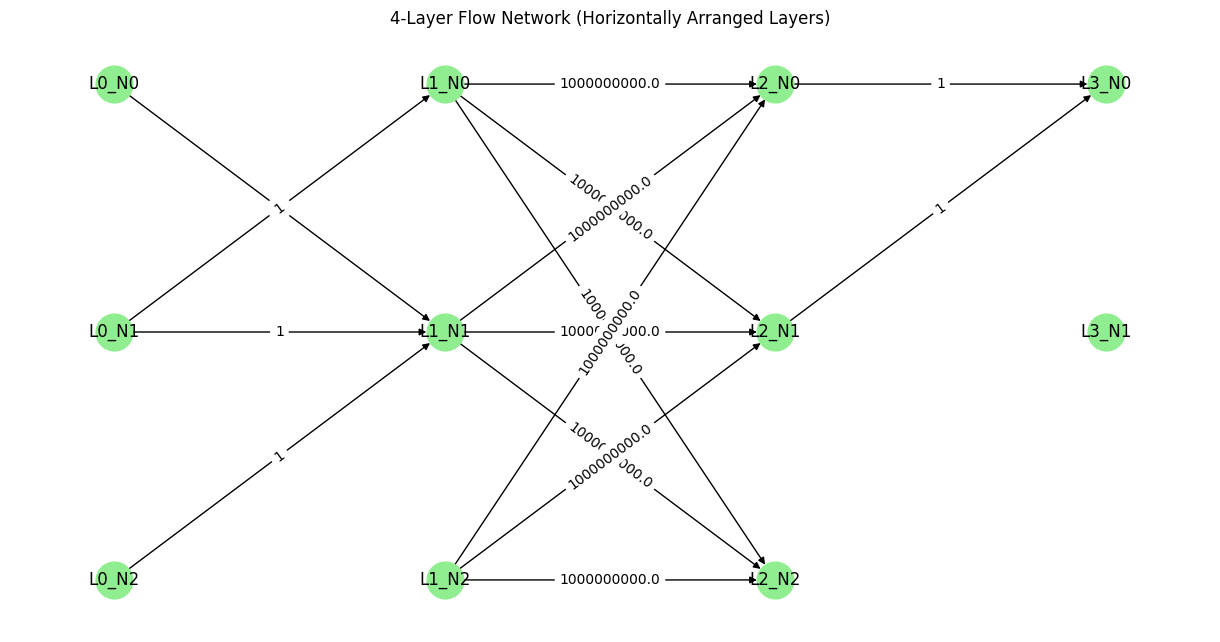

In [ ]:
def get_layer_index(node):
    """Extract the layer index from node name like 'L0_N3'."""
    return int(node[1])

def generate_layered_pos_horizontal(G, layer_gap=4, node_gap=1):
    """
    Generate a layout where layers are arranged horizontally,
    and nodes within each layer are stacked vertically.
    
    Args:
        G: networkx graph
        layer_gap: horizontal distance between layers
        node_gap: vertical distance between nodes in a layer

    Returns:
        dict: mapping from node -> (x, y) position
    """
    pos = {}
    layers = {i: [] for i in range(4)}

    # Group nodes by their layer
    for node in G.nodes:
        layer = get_layer_index(node)
        layers[layer].append(node)
    
    # Assign positions: x = layer index, y = vertical index
    for layer_idx, nodes in layers.items():
        for j, node in enumerate(sorted(nodes)):
            pos[node] = (layer_idx * layer_gap, -j * node_gap)
    
    return pos

# Create layout
pos = generate_layered_pos_horizontal(G)

# Draw the graph
plt.figure(figsize=(12, 6))
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=700, arrows=True)

# Optional: draw edge labels (e.g., capacities)
edge_labels = nx.get_edge_attributes(G, 'capacity')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("4-Layer Flow Network (Horizontally Arranged Layers)")
plt.axis('off')
plt.tight_layout()
plt.show()
